In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score , classification_report

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

https://towardsdatascience.com/a-checklist-for-data-pre-processing-before-you-build-your-machine-learning-model-91d2d04dc53f

# Download ECG Images Dataset

In [ ]:
!mkdir %userprofile%\.kaggle
!copy kaggle.json %userprofile%\.kaggle\

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

# Download Heart Disease Dataset

In [ ]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [4]:
df = pd.concat([X,y],axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
len(df)

303

In [6]:
print(heart_disease.metadata) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [7]:
print(heart_disease.variables) 

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

# Data Preprocessing

## ECG Images

In [8]:
BATCH_SIZE = 128
IM_SHAPE = (224,224,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [9]:
ecg_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./ecg-image-data/ECG_Image_data/train",   
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 99199 files belonging to 6 classes.


In [10]:
ecg_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./ecg-image-data/ECG_Image_data/test",   
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 24799 files belonging to 6 classes.


In [11]:
ecg_train_dataset.class_names

['F', 'M', 'N', 'Q', 'S', 'V']

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 2

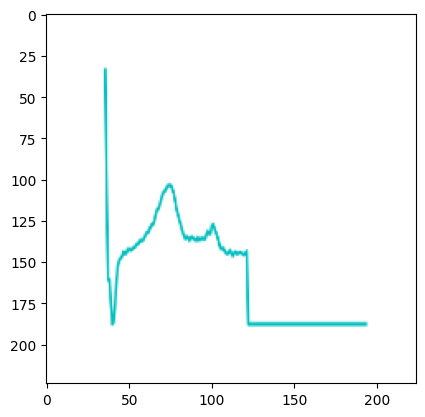

In [12]:
for x in ecg_train_dataset.unbatch():
    plt.imshow(x[0]/255)
    print(x)
    break

In [13]:
def preprocess_images(image, label):
    new_label = tf.where(label == 2, 0, 1)
    new_image = tf.cast(image, tf.float32) / 255.0
    return new_image, new_label


In [14]:
ecg_train_dataset = ecg_train_dataset.map(preprocess_images)
ecg_test_dataset = ecg_test_dataset.map(preprocess_images)

In [15]:
ecg_train_dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
def separate_normal_and_abnormal(ds):
    normal_images = []
    abnormal_images = []
    for batch in ds:
        images,labels = batch
        for image,label in zip(images,labels):
            if label.numpy() == 0:
                normal_images.append(image.numpy())
            else:
                abnormal_images.append(image.numpy())
    random.shuffle(normal_images)
    random.shuffle(abnormal_images)
    return normal_images,abnormal_images


In [17]:
normal_train_images,abnormal_train_images = separate_normal_and_abnormal(ecg_train_dataset)

In [18]:
len(normal_train_images)

75709

In [19]:
len(abnormal_train_images)

23490

In [20]:
normal_test_images,abnormal_test_images = separate_normal_and_abnormal(ecg_test_dataset)

In [21]:
len(normal_test_images),len(abnormal_test_images)

(18926, 5873)

## Structured Data

In [22]:
y.value_counts()

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64

In [23]:
y.loc[:,'num'] = y['num'].apply(lambda x: 1 if x in [1, 2, 3, 4] else 0)

In [24]:
y.value_counts()

num
0      164
1      139
Name: count, dtype: int64

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

In [26]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
185,63,0,2,140,195,0,0,179,0,0.0,1,2.0,3.0
51,65,1,4,120,177,0,0,140,0,0.4,1,0.0,7.0
154,64,1,4,120,246,0,2,96,1,2.2,3,1.0,3.0
235,54,1,4,122,286,0,2,116,1,3.2,2,2.0,3.0
127,54,1,4,110,239,0,0,126,1,2.8,2,1.0,7.0


In [27]:
y_train.head()

,num
185,0
51,0
154,1
235,1
127,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [29]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [30]:
corr = df.corr()
corr

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.362605,0.127389,0.222853
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.093185,0.380936,0.224469
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.233214,0.265246,0.407075
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098773,0.133554,0.157754
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.119000,0.014214,0.070909
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.145478,0.071358,0.059186
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.128343,0.024531,0.183696
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.264246,-0.279631,-0.415040
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.145570,0.329680,0.397057
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.295832,0.341004,0.504092


<Axes: >

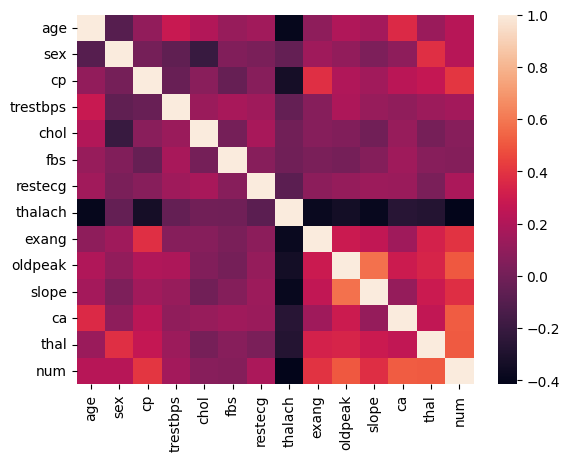

In [31]:
sns.heatmap(corr)

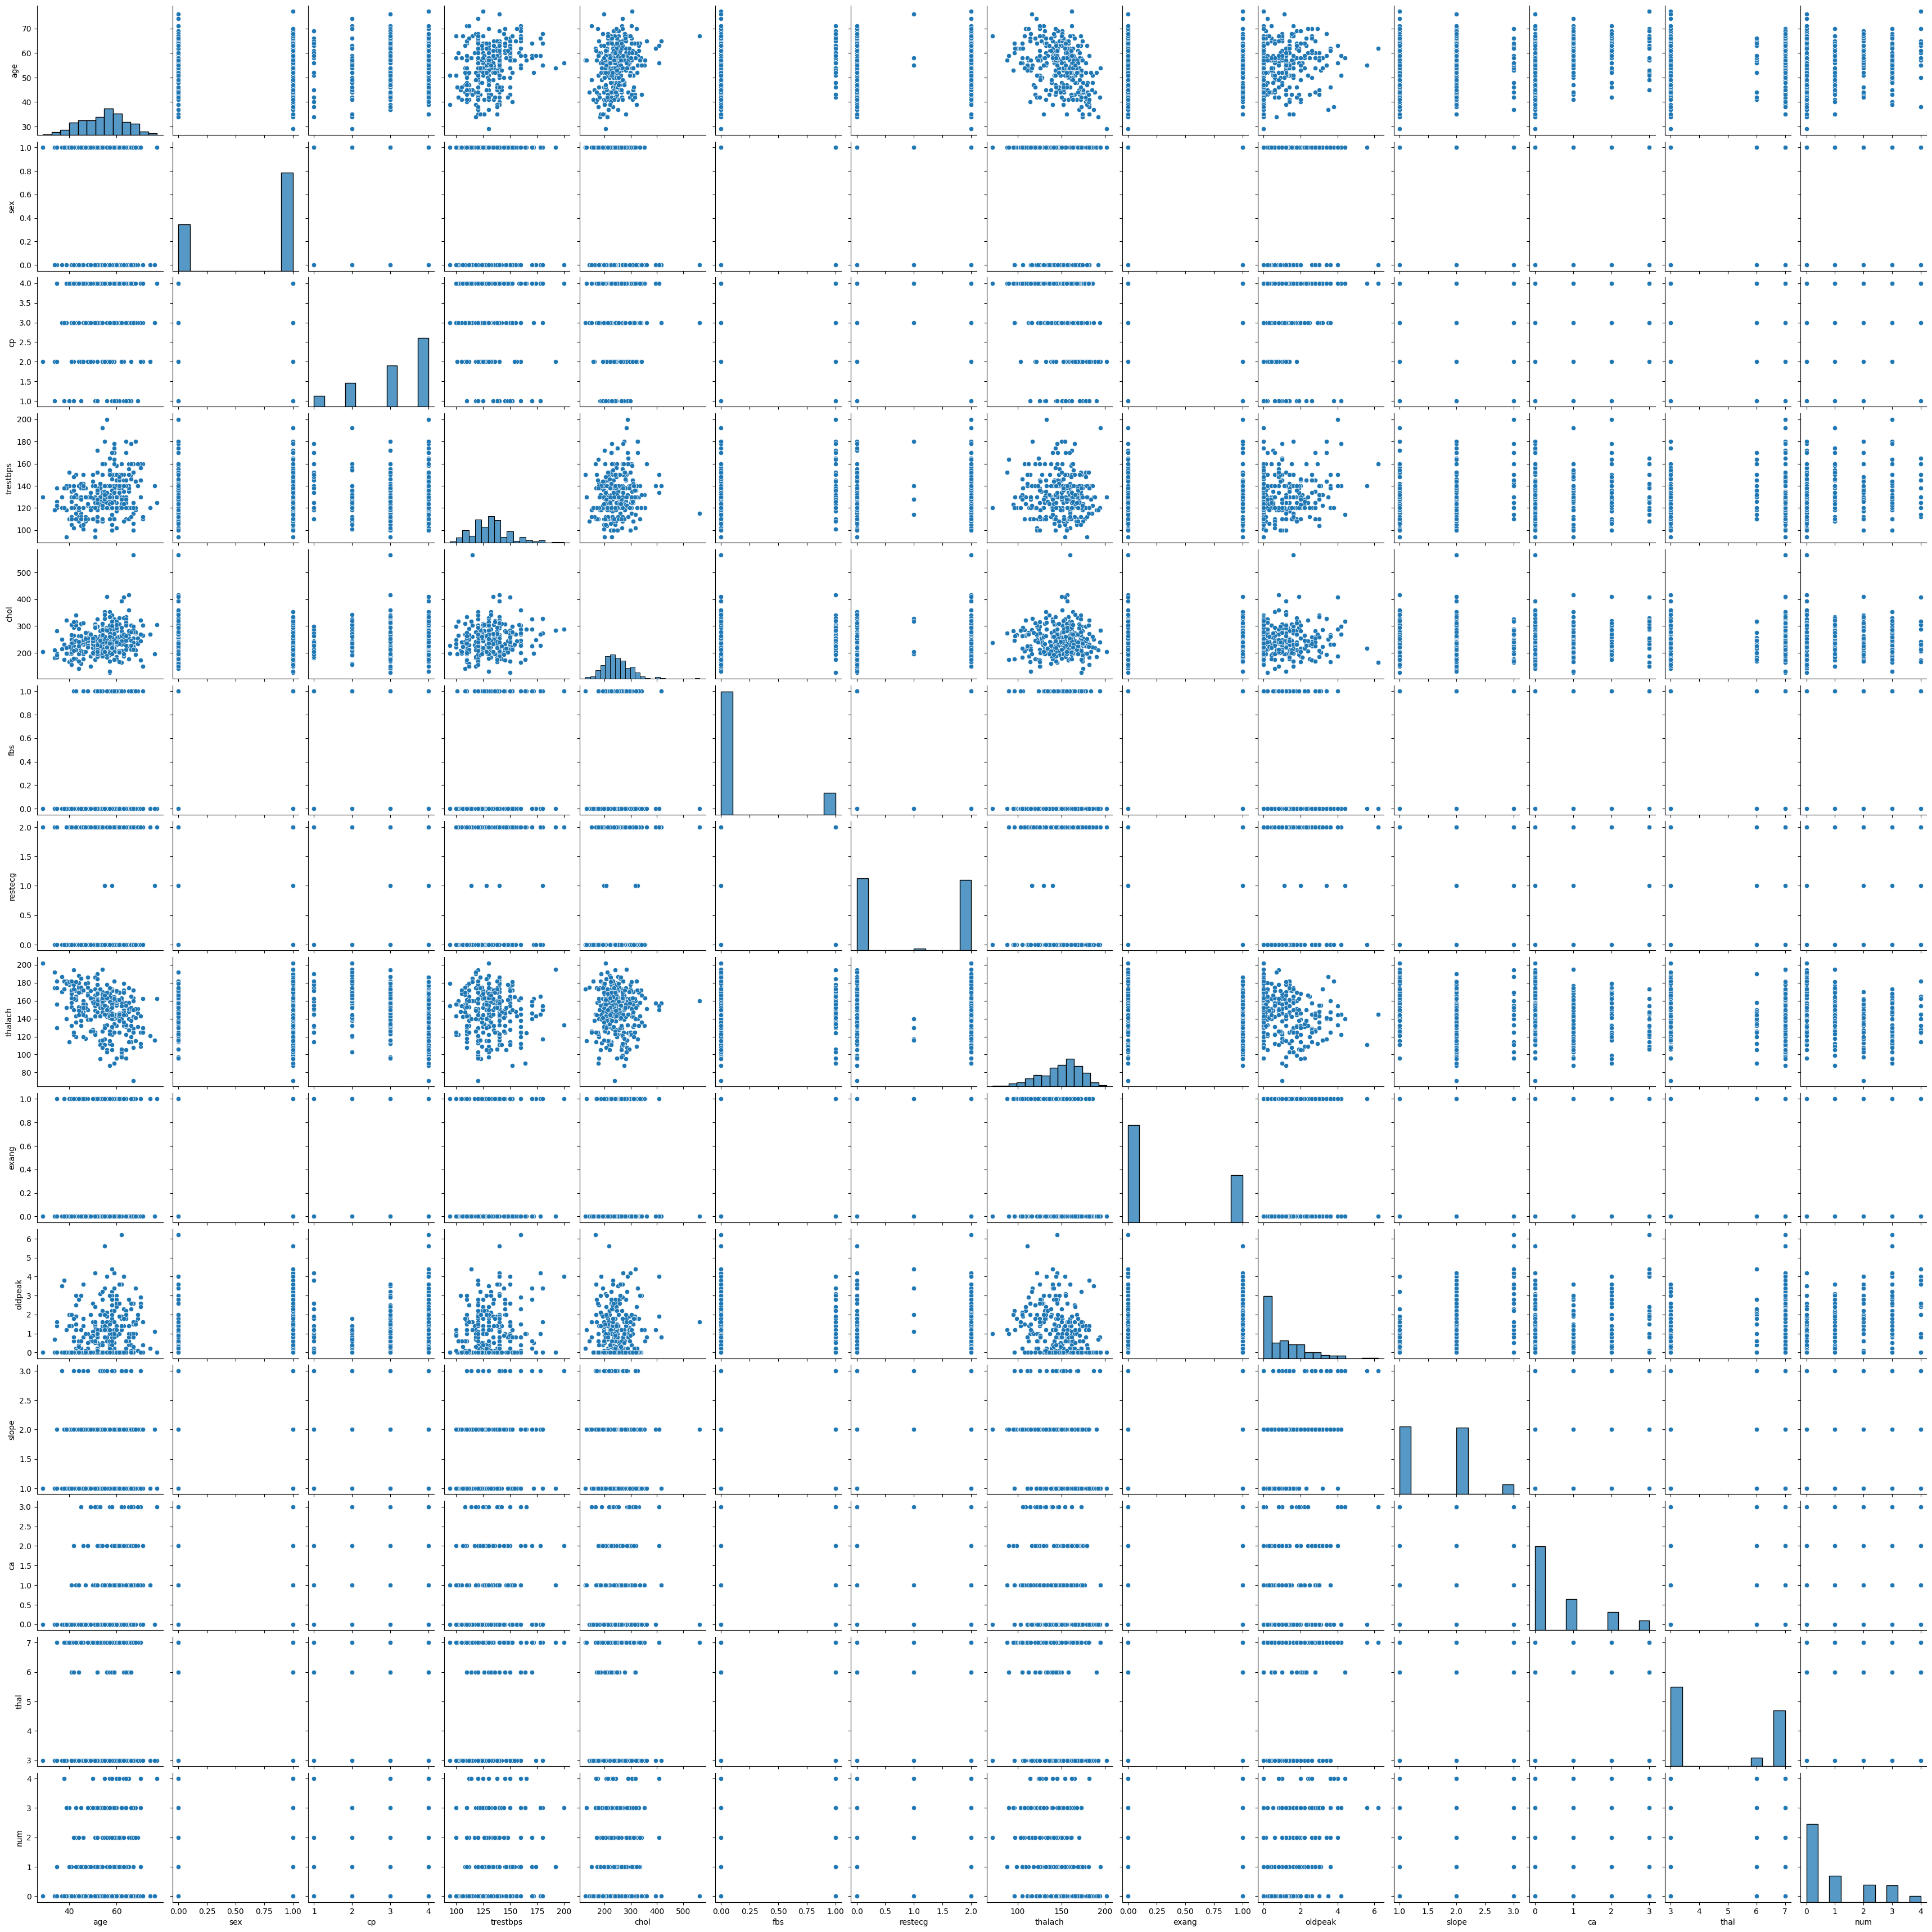

In [51]:
sns.pairplot(df)

In [32]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object

In [33]:
X.skew()

age        -0.209060
sex        -0.774935
cp         -0.841754
trestbps    0.706035
chol        1.135503
fbs         1.986652
restecg     0.019900
thalach    -0.537449
exang       0.742532
oldpeak     1.269720
slope       0.508316
ca          1.189352
thal        0.244447
dtype: float64

- A skewness value of -0.209060 for age suggests a slight skew to the left, meaning more of the data is concentrated on the right side of the mean.
- A skewness value of 1.986652 for fbs (fasting blood sugar) indicates a distribution with a long right tail. This suggests that the majority of the fasting blood sugar values are clustered around the lower end, with fewer high values stretching out to the right.

In [34]:
X.kurtosis()

age        -0.523383
sex        -1.408819
cp         -0.400655
trestbps    0.880074
chol        4.491724
fbs         1.959678
restecg    -1.999331
thalach    -0.053541
exang      -1.458317
oldpeak     1.575813
slope      -0.627521
ca          0.259256
thal       -1.917674
dtype: float64

- A kurtosis value of -0.523383 for age suggests a distribution that is flatter than a normal distribution with fewer outliers.
- A kurtosis value of 4.491724 for chol (cholesterol) suggests a distribution with heavier tails and a sharper peak, meaning there are more extreme values in the cholesterol measurements.

<Axes: >

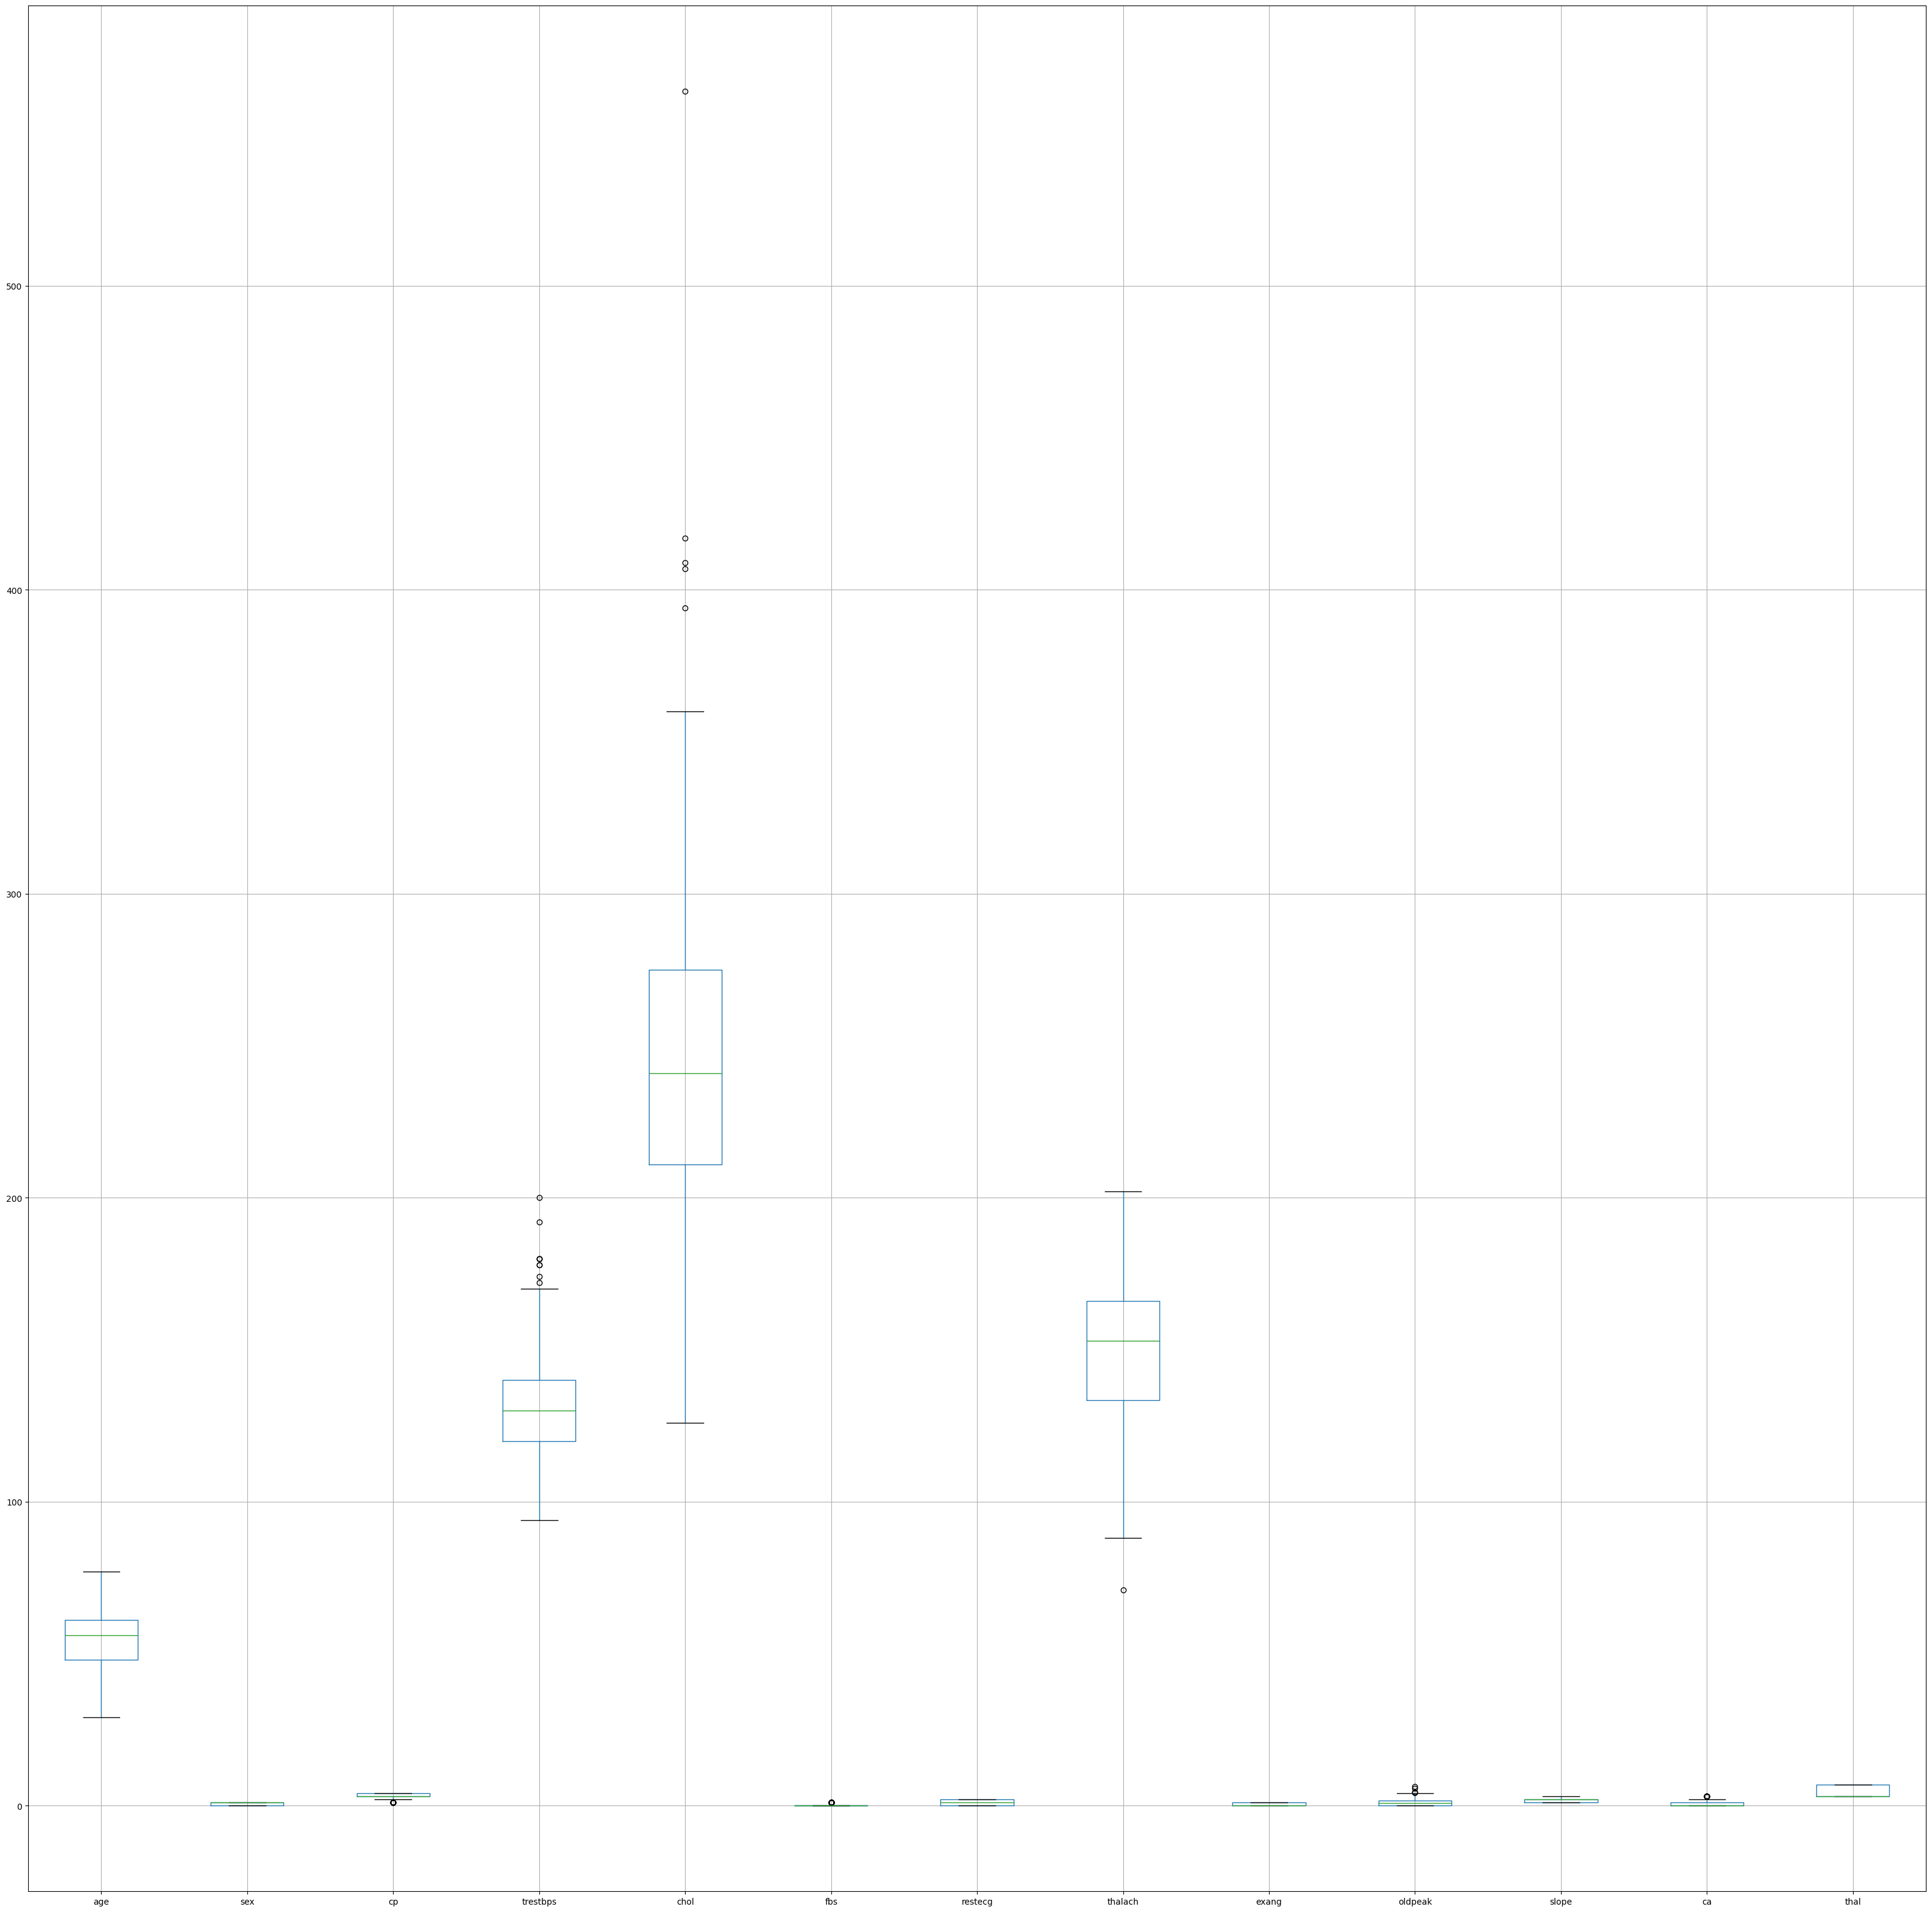

In [35]:
X.boxplot(figsize=(40,40))

In [36]:
null_mask = X_train.isnull().any(axis=1)
null_rows = X_train[null_mask]
null_rows

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN


In [37]:
len(null_rows)/303 *100

1.9801980198019802

Since we have 6 rows with missing values, there are few ways to handle such situations:

- Drop the rows as they only represent 2% of the dataset

- Replace the missing values in thal column with the mode/median value as the column is categorical and replace the missing values in ca column with the mean value as it contains continuous values (using SimpleImputer function from sklearn)

- Use more advanced techniques like KNN

In [38]:
knnImpCopy = KNNImputer(weights="distance")

In [39]:
X_copy= X_train.copy()
X_copy=pd.DataFrame(knnImpCopy.fit_transform(X_copy))
X_copy.columns = X_train.columns

In [40]:
X_copy[X_copy.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal


In [41]:
pca = PCA()
pca.fit(X_copy)

PCA()

In [42]:
pca.explained_variance_ratio_

array([7.40228916e-01, 1.53071951e-01, 8.90009401e-02, 1.55270338e-02,
       9.95983850e-04, 3.40571354e-04, 2.60486046e-04, 2.22598826e-04,
       1.70897588e-04, 5.82691892e-05, 4.94497228e-05, 4.12586649e-05,
       3.16430827e-05])

<BarContainer object of 13 artists>

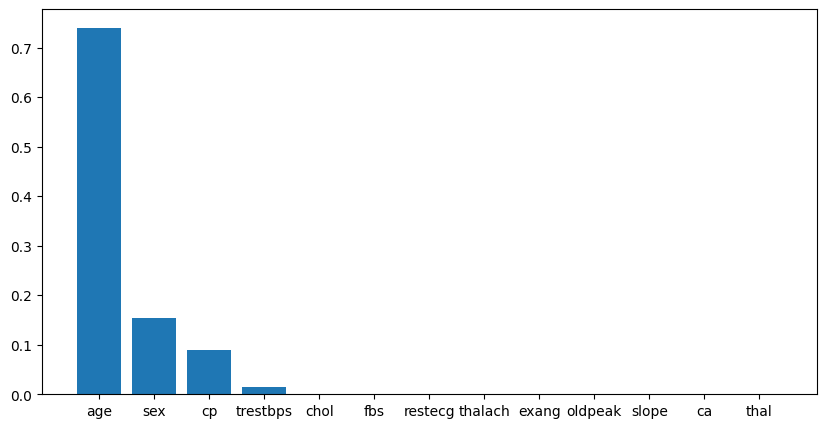

In [43]:
plt.figure(figsize = (10, 5))
plt.bar(X_copy.columns,pca.explained_variance_ratio_)

pca shows that age and sex have the highest variance ratios

In [44]:
np.array(y_train["num"])

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0], dtype=int64)

In [45]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_copy,np.array(y_train["num"]))

LinearDiscriminantAnalysis()

In [46]:
lda.explained_variance_ratio_

array([1.])

<BarContainer object of 1 artists>

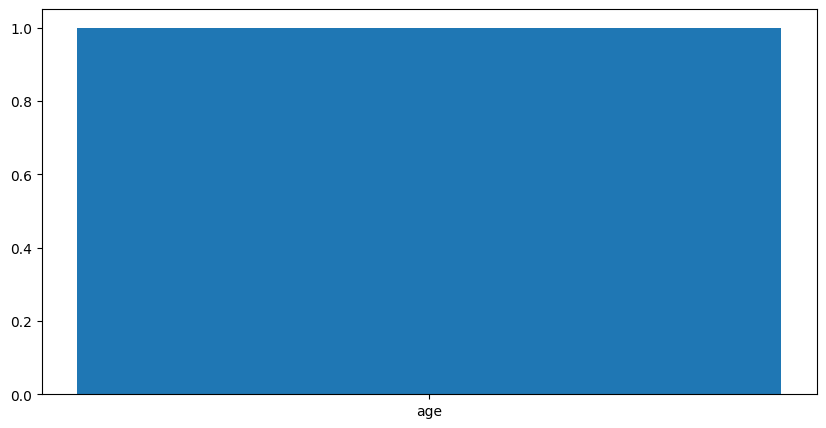

In [47]:
plt.figure(figsize = (10, 5))
plt.bar(X_copy.columns[:len(lda.explained_variance_ratio_)],lda.explained_variance_ratio_)

In [38]:
class CustomKNNImputer:
    def __init__(self, n_neighbors=5, categorical_features=None):
        self.n_neighbors = n_neighbors
        self.categorical_features = categorical_features
        self.knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights="distance")
        self.ohe = OneHotEncoder(handle_unknown='ignore')  
        self.placeholder= 9999

    def fit(self, X, y=None):
        num_cols = X.drop(columns=self.categorical_features, axis=1)
        num_cols_imputed  = self.knn_imputer.fit_transform(num_cols)

        if self.categorical_features is not None:
            cat_data = X[self.categorical_features].fillna(self.placeholder) 
            cat_data_encoded = self.ohe.fit_transform(cat_data)

            X_combined = np.hstack((num_cols_imputed, cat_data_encoded.toarray()))

            self.neighbors = NearestNeighbors(n_neighbors=self.n_neighbors)
            self.neighbors.fit(X_combined)
          
        return self

    def transform(self, X):
        # Transform the numerical columns
        num_cols = X.drop(columns=self.categorical_features)
        X[num_cols.columns] = self.knn_imputer.transform(num_cols)

        # Impute categorical columns
        if self.categorical_features is not None: 
            cat_data = X[self.categorical_features].fillna(self.placeholder)
            cat_data_encoded = self.ohe.transform(cat_data)
            for col_idx,col in enumerate(self.categorical_features):
                missing = X[col].isna()
                if missing.any():
                    cat_data_missing_encoded = cat_data_encoded[missing]
                    X_missing_combined = np.hstack((X[missing].drop(columns=self.categorical_features).values, 
                                                    cat_data_missing_encoded.toarray()))

                    # Find nearest neighbors for the missing rows
                    neighbors_idx = self.neighbors.kneighbors(X_missing_combined, return_distance=False)
                    
                    # Find the most common class among the neighbors
                    print(X.loc[missing,col])
                    for idx, row_idx in enumerate(neighbors_idx):
                        neighbor_cats = self.ohe.inverse_transform(cat_data_encoded[row_idx])
                        neighbor_cats = neighbor_cats[:,col_idx]
                        most_common_value = mode(neighbor_cats[neighbor_cats != self.placeholder]).mode
                        print(idx,neighbor_cats,most_common_value)
                        print('------------------')
                        original_idx = X.index[missing][idx]
                        if most_common_value != self.placeholder:
                            X.loc[original_idx, col] = most_common_value
                        else:
                            X.loc[original_idx, col] = X[col].mode()[0]  # or some other default value
                    print(X.loc[missing,col])
        return X


In [39]:
# knnImp = KNNImputer(weights="distance")
categorical_columns = ["slope", "restecg", "cp","thal"]  
numeric_columns = ["age","trestbps","chol","thalach","oldpeak","ca"]  
knnImp = CustomKNNImputer(categorical_features=categorical_columns)

# Define the column transformer
column_transformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (StandardScaler(), numeric_columns),
    remainder="passthrough"
)

def convert_to_pd_after_imp(np_arr):
    return pd.DataFrame(np_arr,columns=X.columns)
my_transformer = FunctionTransformer(convert_to_pd_after_imp)

data_preprocess_pipeline = make_pipeline(
    knnImp,
    my_transformer,
    column_transformer,
)
data_preprocess_pipeline

Pipeline(steps=[('customknnimputer',
                 <__main__.CustomKNNImputer object at 0x00000186BA570550>),
                ('functiontransformer',
                 FunctionTransformer(func=<function convert_to_pd_after_imp at 0x00000186BA552320>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['slope', 'restecg', 'cp',
                                                   'thal']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca'])]))])

In [40]:
X_transformed = data_preprocess_pipeline.fit_transform(X_train)
transformed_feature_names = data_preprocess_pipeline.named_steps['columntransformer'].get_feature_names_out()
print(transformed_feature_names)
X_transformed_train = pd.DataFrame(X_transformed,index=X_train.index,columns=transformed_feature_names)
X_transformed_train.head()

87    NaN
266   NaN
Name: thal, dtype: float64
0 [9.999e+03 3.000e+00 7.000e+00 7.000e+00 7.000e+00] 7.0
------------------
1 [9.999e+03 3.000e+00 3.000e+00 3.000e+00 3.000e+00] 3.0
------------------
87     7.0
266    3.0
Name: thal, dtype: float64
['onehotencoder__slope_1' 'onehotencoder__slope_2'
 'onehotencoder__slope_3' 'onehotencoder__restecg_0'
 'onehotencoder__restecg_1' 'onehotencoder__restecg_2'
 'onehotencoder__cp_1' 'onehotencoder__cp_2' 'onehotencoder__cp_3'
 'onehotencoder__cp_4' 'onehotencoder__thal_3.0' 'onehotencoder__thal_6.0'
 'onehotencoder__thal_7.0' 'standardscaler__age'
 'standardscaler__trestbps' 'standardscaler__chol'
 'standardscaler__thalach' 'standardscaler__oldpeak' 'standardscaler__ca'
 'remainder__sex' 'remainder__fbs' 'remainder__exang']


,onehotencoder__slope_1,onehotencoder__slope_2,onehotencoder__slope_3,onehotencoder__restecg_0,onehotencoder__restecg_1,onehotencoder__restecg_2,onehotencoder__cp_1,onehotencoder__cp_2,onehotencoder__cp_3,onehotencoder__cp_4,...,onehotencoder__thal_7.0,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang
185,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.934873,0.471356,-0.973080,1.278302,-0.904358,1.395613,0.0,0.0,0.0
51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.154938,-0.668785,-1.314037,-0.407245,-0.557044,-0.729356,1.0,0.0,0.0
154,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.044906,-0.668785,-0.007034,-2.308888,1.005871,0.333129,1.0,0.0,1.0
235,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.055421,-0.554771,0.750650,-1.444505,1.874157,1.395613,1.0,0.0,1.0
127,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,-0.055421,-1.238855,-0.139628,-1.012314,1.526843,0.333129,1.0,0.0,1.0


In [41]:
X_transformed_train[['onehotencoder__thal_3.0','onehotencoder__thal_6.0','onehotencoder__thal_7.0']]


,onehotencoder__thal_3.0,onehotencoder__thal_6.0,onehotencoder__thal_7.0
185,1.0,0.0,0.0
51,0.0,0.0,1.0
154,1.0,0.0,0.0
235,1.0,0.0,0.0
127,0.0,0.0,1.0
...,...,...,...
159,0.0,0.0,1.0
57,0.0,0.0,1.0
158,0.0,0.0,1.0
211,0.0,0.0,1.0


In [42]:
X_train.iloc[[151,191]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
222,39.0,0.0,3,94.0,199.0,0.0,0,179.0,0.0,0.0,1,0.0,3.0
25,50.0,0.0,3,120.0,219.0,0.0,0,158.0,0.0,1.6,2,0.0,3.0


In [44]:
X_train.loc[[151,190]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
151,42.0,0.0,4,102.0,265.0,0.0,2,122.0,0.0,0.6,2,0.0,3.0
190,50.0,1.0,3,129.0,196.0,0.0,0,163.0,0.0,0.0,1,0.0,3.0


In [45]:
X_train.loc[[87,266]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53.0,0.0,3,128.0,216.0,0.0,2,115.0,0.0,0.0,1,0.0,7.0
266,52.0,1.0,4,128.0,204.0,1.0,0,156.0,1.0,1.0,2,0.0,3.0


In [46]:

X_transformed_train.loc[[87,266]][['onehotencoder__thal_3.0','onehotencoder__thal_6.0','onehotencoder__thal_7.0']]

,onehotencoder__thal_3.0,onehotencoder__thal_6.0,onehotencoder__thal_7.0
87,0.0,0.0,1.0
266,1.0,0.0,0.0


In [47]:
len(X_transformed_train)

272

In [48]:
y_train.head()

,num
185,0
51,0
154,1
235,1
127,1


In [49]:
train_df = pd.concat([X_transformed_train,y_train],axis=1)
train_df

,onehotencoder__slope_1,onehotencoder__slope_2,onehotencoder__slope_3,onehotencoder__restecg_0,onehotencoder__restecg_1,onehotencoder__restecg_2,onehotencoder__cp_1,onehotencoder__cp_2,onehotencoder__cp_3,onehotencoder__cp_4,...,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang,num
185,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.934873,0.471356,-0.973080,1.278302,-0.904358,1.395613,0.0,0.0,0.0,0
51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.154938,-0.668785,-1.314037,-0.407245,-0.557044,-0.729356,1.0,0.0,0.0,0
154,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.044906,-0.668785,-0.007034,-2.308888,1.005871,0.333129,1.0,0.0,1.0,1
235,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.055421,-0.554771,0.750650,-1.444505,1.874157,1.395613,1.0,0.0,1.0,1
127,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.055421,-1.238855,-0.139628,-1.012314,1.526843,0.333129,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.485036,-0.782799,0.580171,0.068166,-0.036072,0.333129,1.0,0.0,0.0,0
57,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-1.485845,-1.238855,-1.408748,0.370700,-0.904358,-0.729356,1.0,0.0,0.0,1
158,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.604775,0.471356,0.883244,0.889330,0.137585,1.395613,1.0,0.0,0.0,1
211,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.815943,-0.668785,-0.291165,1.407960,2.395129,-0.729356,1.0,0.0,1.0,1


In [50]:
X_transformed_train[X_transformed_train.isnull().any(axis=1)]

,onehotencoder__slope_1,onehotencoder__slope_2,onehotencoder__slope_3,onehotencoder__restecg_0,onehotencoder__restecg_1,onehotencoder__restecg_2,onehotencoder__cp_1,onehotencoder__cp_2,onehotencoder__cp_3,onehotencoder__cp_4,...,onehotencoder__thal_7.0,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang


In [51]:
len(X_transformed_train)

272

In [52]:
len(y_train)

272

<BarContainer object of 2 artists>

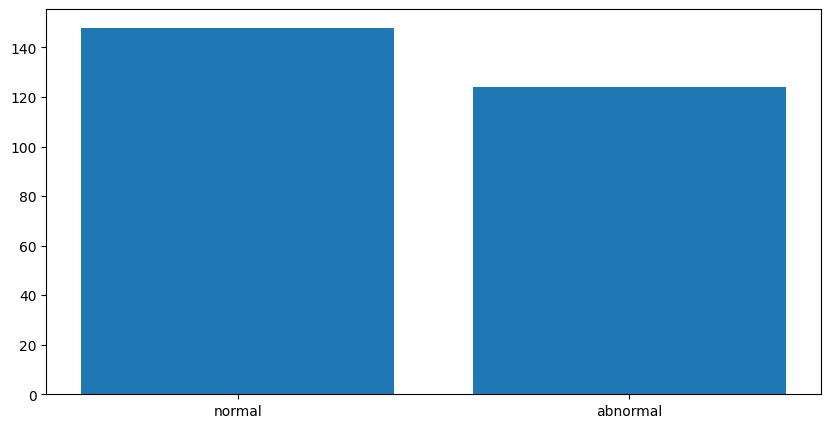

In [53]:
plt.figure(figsize=(10,5))
plt.bar(["normal","abnormal"],y_train.value_counts())

In [54]:
X_transformed_test = data_preprocess_pipeline.transform(X_test)
transformed_feature_names_test = data_preprocess_pipeline.named_steps['columntransformer'].get_feature_names_out()
X_transformed_test = pd.DataFrame(X_transformed_test,index=X_test.index,columns=transformed_feature_names_test) 

missing_columns = set(X_transformed_train.columns) - set(X_transformed_test.columns)

for column in missing_columns:
    X_transformed_test[column] = 0

# Optionally, re-order the columns of X_transformed_test to match X_transformed_train
X_transformed_test = X_transformed_test[X_transformed_train.columns]
X_transformed_test.head()

,onehotencoder__slope_1,onehotencoder__slope_2,onehotencoder__slope_3,onehotencoder__restecg_0,onehotencoder__restecg_1,onehotencoder__restecg_2,onehotencoder__cp_1,onehotencoder__cp_2,onehotencoder__cp_3,onehotencoder__cp_4,...,onehotencoder__thal_7.0,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang
27,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.264971,1.041426,-0.385875,-1.530944,1.353186,-0.729356,0.0,0.0,0.0
184,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.604775,1.497483,1.110549,0.500357,-0.904358,-0.729356,0.0,0.0,0.0
247,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,-0.825649,-1.238855,0.542287,-1.358067,-0.036072,0.333129,1.0,0.0,1.0
268,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,-1.595878,1.155440,-0.442701,1.364740,-0.904358,-0.729356,1.0,0.0,0.0
167,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,-0.055421,0.015300,0.788534,0.413919,-0.904358,0.333129,0.0,1.0,1.0


In [55]:
X_transformed_test.columns==X_transformed_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [56]:
test_df = pd.concat([X_transformed_test,y_test],axis=1)

In [57]:
test_df

,onehotencoder__slope_1,onehotencoder__slope_2,onehotencoder__slope_3,onehotencoder__restecg_0,onehotencoder__restecg_1,onehotencoder__restecg_2,onehotencoder__cp_1,onehotencoder__cp_2,onehotencoder__cp_3,onehotencoder__cp_4,...,standardscaler__age,standardscaler__trestbps,standardscaler__chol,standardscaler__thalach,standardscaler__oldpeak,standardscaler__ca,remainder__sex,remainder__fbs,remainder__exang,num
27,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.264971,1.041426,-0.385875,-1.530944,1.353186,-0.729356,0.0,0.0,0.0,0
184,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.604775,1.497483,1.110549,0.500357,-0.904358,-0.729356,0.0,0.0,0.0,1
247,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.825649,-1.238855,0.542287,-1.358067,-0.036072,0.333129,1.0,0.0,1.0,1
268,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.595878,1.155440,-0.442701,1.364740,-0.904358,-0.729356,1.0,0.0,0.0,1
167,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.055421,0.015300,0.788534,0.413919,-0.904358,0.333129,0.0,1.0,1.0,0
195,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.375004,-1.808925,0.996897,-1.055533,-0.122901,1.395613,1.0,0.0,1.0,1
191,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.385519,0.471356,0.977954,-1.185190,2.742444,2.458097,1.0,0.0,1.0,1
283,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.146041,-0.554771,-1.029906,1.062206,-0.904358,-0.729356,1.0,0.0,0.0,0
105,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.055421,-1.352869,1.186317,0.284261,-0.904358,-0.729356,1.0,0.0,0.0,0
23,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.384710,0.015300,-0.423759,1.018987,1.874157,1.395613,1.0,0.0,0.0,1


## Combine 2 datasets

In [58]:
num_structured_features = len(X_transformed_train.columns)

In [59]:
def combine_ds(normal_images,abnormal_images,preprocessed_df,num_images_per_record=5):
    combined_data = []

    for _, row in preprocessed_df.iterrows():
        label = row['num']
        if label == 0:
            selected_images = random.sample(normal_images, num_images_per_record)
        else:
            selected_images = random.sample(abnormal_images, num_images_per_record)

        for img in selected_images:
            combined_data.append((row.iloc[:-1], img, label))
    random.shuffle(combined_data)
    return combined_data

In [60]:
combined_train_data = combine_ds(normal_train_images,abnormal_train_images,train_df)

In [61]:
len(combined_train_data)

1360

In [62]:
combined_test_data = combine_ds(normal_test_images,abnormal_test_images,test_df)

In [63]:
def create_generator(combined_data):
    def generator():
        for row, img, label in combined_data:
            structured_data = row.to_numpy()
            yield (structured_data, img), label
    return generator

# Create specific generator functions for training and testing
train_generator = create_generator(combined_train_data)
test_generator = create_generator(combined_test_data)

In [64]:
# Adjust output_types and output_shapes to match the structure yielded by the generator
train_ds = tf.data.Dataset.from_generator(
    train_generator,
    output_types=((tf.float32, tf.float32), tf.int32),
    output_shapes=(((num_structured_features,), (224, 224, 3)), ())  
)

test_ds = tf.data.Dataset.from_generator(
    test_generator,
    output_types=((tf.float32, tf.float32), tf.int32),
    output_shapes=(((num_structured_features,), (224, 224, 3)), ()) 
)

In [65]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [66]:
train_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(
[ 0.          1.          0.          1.          0.          0.
  0.          0.          1.          0.          1.          0.
  0.         -0.38551885 -1.8089254  -0.46164355 -0.2775878   0.13758506
 -0.7293559   1.          0.          1.        ], shape=(22,), dtype=float32)


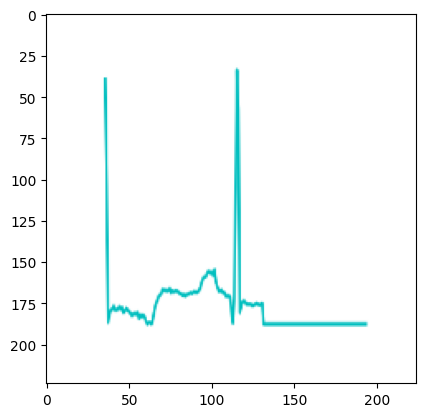

In [67]:
for inp,label in train_ds.unbatch():
    record, image = inp
    print(label)
    print(record)
    plt.imshow(image)
    break

## Lets pipeline the method of creating datasets

In [68]:
def create_ds(curr_data):
    curr_generator = create_generator(curr_data)
    ds = tf.data.Dataset.from_generator(
        curr_generator,
        output_types=((tf.float32, tf.float32), tf.int32),
        output_shapes=(((num_structured_features,), (224, 224, 3)), ())  
    )
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

### Data Augmentation

In [69]:
def augment_image(image, label):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

In [70]:
def apply_augmentation(inp, label):
    structured_data, image = inp
    image, label = augment_image(image, label)
    return (structured_data, image), label

In [71]:
aug_train_ds = train_ds.map(apply_augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(
[ 0.          1.          0.          1.          0.          0.
  0.          0.          1.          0.          1.          0.
  0.         -0.38551885 -1.8089254  -0.46164355 -0.2775878   0.13758506
 -0.7293559   1.          0.          1.        ], shape=(22,), dtype=float32)


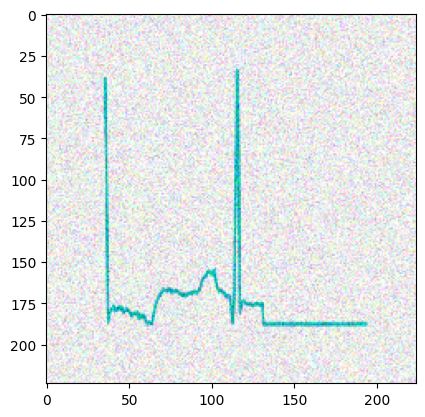

In [73]:
for inp,label in aug_train_ds.unbatch():
    record, image = inp
    print(label)
    print(record)
    plt.imshow(image)
    break

# Multimodal model

In [81]:
# Input for structured data
structured_input = Input(shape=(num_structured_features,), name='structured_data_input')
structured_branch = Dense(64, activation='relu')(structured_input)
structured_branch = Dense(32, activation='relu')(structured_branch)

# Input for images
image_input = Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3), name='image_input')
image_branch = Conv2D(32, (3, 3), activation='relu')(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Flatten()(image_branch)

combined = concatenate([structured_branch, image_branch])
combined = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)
model_1 = Model(inputs=[structured_input, image_input], outputs=output)

In [82]:
model_1

In [83]:
optimizer = Adam(learning_rate=0.005)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(train_ds, epochs=10)

Epoch 1/10
11/11 [==============================] - 8s 148ms/step - loss: 42.1390 - accuracy: 0.5235
Epoch 2/10
11/11 [==============================] - 1s 46ms/step - loss: 2.0652 - accuracy: 0.5412
Epoch 3/10
11/11 [==============================] - 1s 46ms/step - loss: 0.6754 - accuracy: 0.8404
Epoch 4/10
11/11 [==============================] - 1s 49ms/step - loss: 0.8542 - accuracy: 0.8331
Epoch 5/10
11/11 [==============================] - 1s 46ms/step - loss: 0.2380 - accuracy: 0.9353
Epoch 6/10
11/11 [==============================] - 1s 46ms/step - loss: 0.0597 - accuracy: 0.9882
Epoch 7/10
11/11 [==============================] - 1s 47ms/step - loss: 0.0287 - accuracy: 0.9941
Epoch 8/10
11/11 [==============================] - 1s 47ms/step - loss: 0.2928 - accuracy: 0.9176
Epoch 9/10
11/11 [==============================] - 1s 46ms/step - loss: 0.0625 - accuracy: 0.9831
Epoch 10/10
11/11 [==============================] - 1s 47ms/step - loss: 0.0217 - accuracy: 0.9919


In [84]:
model_1.evaluate(test_ds)

2/2 [==============================] - 0s 231ms/step - loss: 0.0494 - accuracy: 0.9871


[0.0494055300951004, 0.9870967864990234]

In [91]:
model_1.save('./models/model_1')

INFO:tensorflow:Assets written to: ./models/model_1\assets


INFO:tensorflow:Assets written to: ./models/model_1\assets


## Lets try out the augmented data for fun :)

In [85]:
model_2 = Model.from_config(model_1.get_config())

In [86]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 structured_data_input (InputLa  [(None, 22)]        0           []                               
 yer)                                                                                             
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['image_input[0][0]']            
                                )                                                             

In [87]:
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_2.fit(aug_train_ds, epochs=10)

Epoch 1/10
11/11 [==============================] - 8s 650ms/step - loss: 56.6094 - accuracy: 0.5522
Epoch 2/10
11/11 [==============================] - 7s 640ms/step - loss: 0.1617 - accuracy: 0.9787
Epoch 3/10
11/11 [==============================] - 7s 666ms/step - loss: 0.1502 - accuracy: 0.9610
Epoch 4/10
11/11 [==============================] - 7s 650ms/step - loss: 7.8371 - accuracy: 0.8059
Epoch 5/10
11/11 [==============================] - 7s 647ms/step - loss: 1.3178 - accuracy: 0.7868
Epoch 6/10
11/11 [==============================] - 8s 687ms/step - loss: 0.0499 - accuracy: 0.9868
Epoch 7/10
11/11 [==============================] - 7s 659ms/step - loss: 0.0465 - accuracy: 0.9919
Epoch 8/10
11/11 [==============================] - 7s 656ms/step - loss: 0.0407 - accuracy: 0.9897
Epoch 9/10
11/11 [==============================] - 7s 661ms/step - loss: 0.0280 - accuracy: 0.9956
Epoch 10/10
11/11 [==============================] - 7s 649ms/step - loss: 0.0186 - accuracy: 0.999

In [88]:
model_2.evaluate(test_ds)

2/2 [==============================] - 0s 22ms/step - loss: 0.0133 - accuracy: 1.0000


[0.01333229336887598, 1.0]

In [92]:
model_2.save('./models/model_2')

INFO:tensorflow:Assets written to: ./models/model_2\assets


INFO:tensorflow:Assets written to: ./models/model_2\assets


## Cross Validation

In [128]:
z = [(1,2,3),(2,3,4)]
y = [(1,2,3),(2,36,4)]
z+=y
print(z)

[(1, 2, 3), (2, 3, 4), (1, 2, 3), (2, 36, 4)]


In [138]:
combined_data = combined_train_data + combined_test_data
random.shuffle(combined_data)

In [150]:
z = [(0,3,2),(2,1,0)]
z = np.array(z)
z[:,0]

array([0, 2])

In [153]:
num_folds = 5
fold_size = len(combined_data)//num_folds
fold_results = []
for fold in range(num_folds):
    start = fold*fold_size
    end = (fold+1)*fold_size
    test_data = combined_data[start:end]
    curr_test_ds = create_ds(test_data)
    train_data = combined_data[0:start] + combined_data[end:]
    curr_train_ds = create_ds(train_data)
    curr_model = Model.from_config(model_1.get_config())
    curr_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print(f'Model {fold} starts training: ')
    curr_model.fit(curr_train_ds, epochs=10)
    print(f'Model {fold} evaluates: ')
    loss,acc = curr_model.evaluate(curr_test_ds)
    fold_results.append((loss,acc))
    print("-------------------------------------------------------")
fold_results

Model 0 starts training: 
Epoch 1/10
10/10 [==============================] - 1s 47ms/step - loss: 132.1398 - accuracy: 0.4802
Epoch 2/10
10/10 [==============================] - 0s 47ms/step - loss: 16.2689 - accuracy: 0.5264
Epoch 3/10
10/10 [==============================] - 0s 45ms/step - loss: 13.2432 - accuracy: 0.5363
Epoch 4/10
10/10 [==============================] - 0s 45ms/step - loss: 3.7067 - accuracy: 0.7054
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 3.4704 - accuracy: 0.7962
Epoch 6/10
10/10 [==============================] - 0s 45ms/step - loss: 2.3308 - accuracy: 0.8226
Epoch 7/10
10/10 [==============================] - 0s 46ms/step - loss: 1.3765 - accuracy: 0.8573
Epoch 8/10
10/10 [==============================] - 0s 46ms/step - loss: 0.8374 - accuracy: 0.8804
Epoch 9/10
10/10 [==============================] - 0s 45ms/step - loss: 0.4594 - accuracy: 0.8886
Epoch 10/10
10/10 [==============================] - 0s 46ms/step - loss: 0.306

3/3 [==============================] - 0s 24ms/step - loss: 0.2688 - accuracy: 0.9274
-------------------------------------------------------
Model 1 starts training: 
Epoch 1/10
10/10 [==============================] - 1s 48ms/step - loss: 133.3206 - accuracy: 0.5891
Epoch 2/10
10/10 [==============================] - 0s 45ms/step - loss: 0.1565 - accuracy: 0.9926
Epoch 3/10
10/10 [==============================] - 0s 45ms/step - loss: 2.7509 - accuracy: 0.7071
Epoch 4/10
10/10 [==============================] - 0s 45ms/step - loss: 0.5085 - accuracy: 0.7401
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 0.3682 - accuracy: 0.8515
Epoch 6/10
10/10 [==============================] - 0s 45ms/step - loss: 0.3152 - accuracy: 0.8713
Epoch 7/10
10/10 [==============================] - 0s 45ms/step - loss: 0.2706 - accuracy: 0.8894
Epoch 8/10
10/10 [==============================] - 0s 45ms/step - loss: 0.2363 - accuracy: 0.8977
Epoch 9/10
10/10 [====================

[(0.26878097653388977, 0.9273927211761475),
 (0.21548545360565186, 0.9240924119949341),
 (0.36609160900115967, 0.8646864891052246),
 (0.2678421139717102, 0.9042904376983643),
 (0.3323577642440796, 0.9108911156654358)]

In [155]:
fold_results = np.array(fold_results)

In [164]:
mean_loss, mean_acc = np.mean(fold_results,axis=0)
mean_loss, mean_acc

(0.29011158347129823, 0.9062706351280212)

Text(0, 0.5, 'loss')

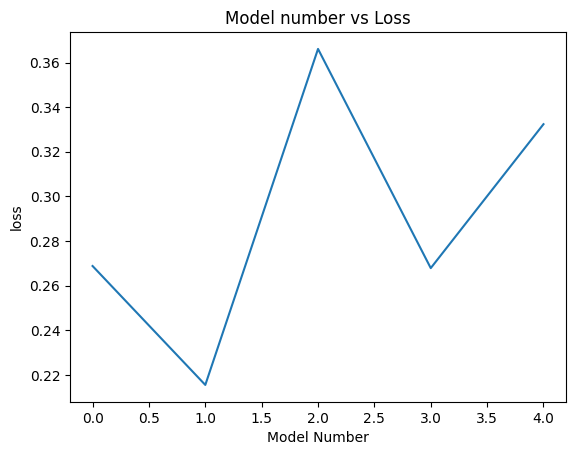

In [160]:
plt.plot(np.arange(0,5),fold_results[:,0])
plt.title("Model number vs Loss")
plt.xlabel("Model Number")
plt.ylabel("loss")

Text(0, 0.5, 'Accuracy')

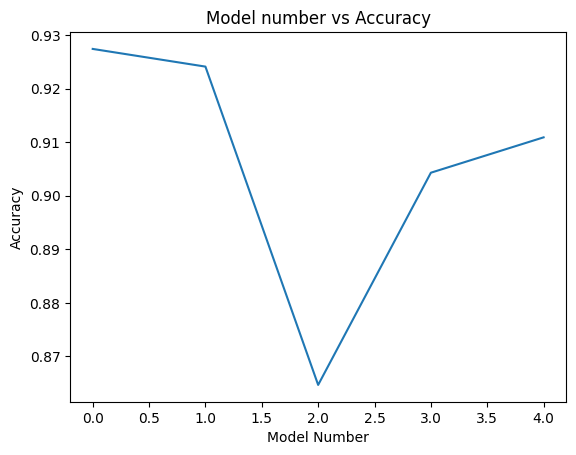

In [161]:
plt.plot(np.arange(0,5),fold_results[:,1])
plt.title("Model number vs Accuracy")
plt.xlabel("Model Number")
plt.ylabel("Accuracy")

## SVC

In [74]:
def separated_combined_data(curr_data):
    separated_struct_data = []
    separated_img = []
    separated_labels = []
    for tup in curr_data:
        separated_struct_data.append(tup[0])
        separated_img.append(tup[1])
        separated_labels.append(tup[2])
    
    return np.array(separated_struct_data), np.array(separated_img), np.array(separated_labels)

In [75]:
separated_train_struct_data, separated_train_img_data, separated_train_labels =  separated_combined_data(combined_train_data)

In [76]:
len(separated_train_struct_data)

1360

In [77]:
separated_test_struct_data, separated_test_img_data, separated_test_labels =  separated_combined_data(combined_test_data)

### Using all image features

In [78]:
def flatten_images(separated_img_data):
    separated_img_data_flat = []
    for image in separated_img_data:
        separated_img_data_flat.append(image.flatten())
    return np.array(separated_img_data_flat)

In [79]:
separated_train_img_data_flattened = flatten_images(separated_train_img_data)
separated_test_img_data_flattened = flatten_images(separated_test_img_data)

In [80]:
separated_train_img_data_flattened.shape

(1360, 150528)

In [81]:
224*224*3

150528

In [82]:
np.concatenate([[[1,2,3]],[[2,3,4]]],axis=1)

array([[1, 2, 3, 2, 3, 4]])

In [85]:
param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 

svc=SVC(probability=True) 
model_3=GridSearchCV(svc,param_grid)


In [98]:
separated_train_input = np.concatenate([separated_train_struct_data,separated_train_img_data_flattened],axis=1)

In [96]:
separated_test_input = np.concatenate([separated_test_struct_data,separated_test_img_data_flattened],axis=1)

In [99]:
model_3.fit(separated_train_input,separated_train_labels)

KeyboardInterrupt: 

In [ ]:
y_pred = model_3.predict(separated_test_input) 
  
accuracy = accuracy_score(y_pred, separated_test_labels) 

In [ ]:
accuracy

### Using the most important features of the images

In [83]:
pca_for_images = PCA(n_components=50)
train_image_features = pca_for_images.fit_transform(separated_train_img_data_flattened)
test_image_features = pca_for_images.transform(separated_test_img_data_flattened)

In [86]:
svc_2=SVC(probability=True) 
model_4=GridSearchCV(svc_2,param_grid)

In [88]:
separated_train_input_reduced = np.concatenate([separated_train_struct_data,train_image_features],axis=1)

In [89]:
model_4.fit(separated_train_input_reduced,separated_train_labels)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [92]:
separated_test_input_reduced = np.concatenate([separated_test_struct_data,test_image_features],axis=1)

In [93]:
y_pred_2 = model_4.predict(separated_test_input_reduced) 
  
# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred_2, separated_test_labels) 

In [94]:
accuracy

1.0